In [10]:
from glob import glob
from src import Module, DataModule, DatasetFCI, DatasetFCIm
import torch 
import torchmetrics 
from tqdm import tqdm
import os 
from skimage import io
import shutil
import numpy as np
import pandas as pd

In [2]:
checkpoints = glob('./checkpoints/*')
checkpoints

['./checkpoints/unetpp-rs50-fcim-lrs-val_metric=0.67217-epoch=16.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-epoch=29.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-epoch=99.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-focal-val_metric=0.00334-epoch=0.ckpt',
 './checkpoints/unetpp-rs50-fcim-da-epoch=29.ckpt',
 './checkpoints/unetpp-rs50-fcim-da-epoch=29-v1.ckpt',
 './checkpoints/unetpp-rs50-fcim-da-val_metric=0.67048-epoch=26.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-focal-epoch=9.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-val_metric=0.68205-epoch=15.ckpt',
 './checkpoints/unetpp-rs50-fcim-da-val_metric=0.66485-epoch=29.ckpt']

In [3]:
name = "unetpp-rs50-fcim-lrs-val_metric=0.68205-epoch=15.ckpt"
checkpoint = f'./checkpoints/{name}'

# module = Module.load_from_checkpoint(checkpoint)

state_dict = torch.load(checkpoint, map_location='cpu')['state_dict']
module = Module({"encoder": "timm-resnest50d", "in_chans": 5, "pretrained": None, "padding": 1, "mask_loss": True, "architecture": "UnetPlusPlus"})
module.load_state_dict(state_dict)


<All keys matched successfully>

Threshold tuning

In [21]:
def eval_th(model, device=0, mask_loss=False, th=0.5):
	# dm = DataModule(false_color=True, t=[4], val_trans={'Resize': {"height":384, 'width':384}})
	dm = DataModule(Dataset="DatasetFCIm")
	dm.setup()
	model.eval()
	model.cuda(device)
	metric = torchmetrics.Dice(threshold=th).cuda(device)
	with torch.no_grad():
		pbar = tqdm(dm.val_dataloader())
		for batch in pbar:
			x, y = batch
			if mask_loss: x = x[...,:-1]
			y_hat = model(x.cuda(device))
			metric(y_hat, y.cuda(device).unsqueeze(1))
			dice = metric.compute().cpu().item()
			pbar.set_description(f'Dice: {dice:.5f}')
	return dice

In [33]:
thresholds = np.linspace(0.1, 0.9, 10)
data = []
for th in thresholds:
	print(f"Threshold: {th}")
	dice = eval_th(module, mask_loss=True, th=th)
	data.append((th, dice))

Threshold: 0.1


  0%|          | 0/36 [00:00<?, ?it/s]

Dice: 0.68229: 100%|██████████| 36/36 [00:16<00:00,  2.20it/s]


Threshold: 0.18888888888888888


Dice: 0.68230: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]


Threshold: 0.2777777777777778


Dice: 0.68229: 100%|██████████| 36/36 [00:16<00:00,  2.17it/s]


Threshold: 0.3666666666666667


Dice: 0.68226: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s]


Threshold: 0.4555555555555556


Dice: 0.68221: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]


Threshold: 0.5444444444444445


Dice: 0.68218: 100%|██████████| 36/36 [00:16<00:00,  2.21it/s]


Threshold: 0.6333333333333333


Dice: 0.68212: 100%|██████████| 36/36 [00:16<00:00,  2.19it/s]


Threshold: 0.7222222222222222


Dice: 0.68209: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]


Threshold: 0.8111111111111111


Dice: 0.68207: 100%|██████████| 36/36 [00:16<00:00,  2.17it/s]


Threshold: 0.9


Dice: 0.68203: 100%|██████████| 36/36 [00:16<00:00,  2.19it/s]


<Axes: xlabel='Threshold'>

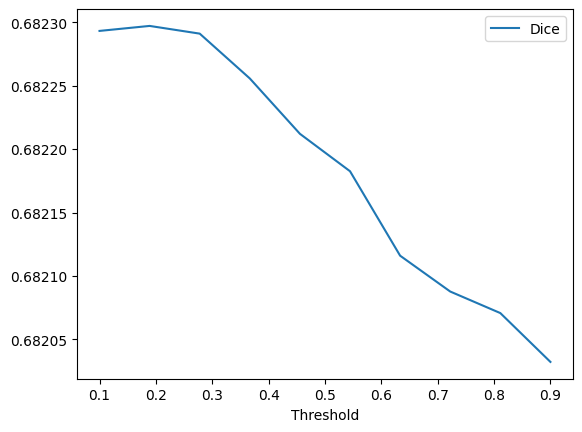

In [34]:
df = pd.DataFrame(data, columns=["Threshold", "Dice"])
df.plot(x="Threshold", y="Dice")

In [38]:
# get threhsold with best dice

best_th = df[df.Dice == df.Dice.max()].Threshold.values[0]
best_th

0.18888888888888888